In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.cort_processor import *

from src.plotter import *
from src.filters import *
import math
import pickle
import scipy
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import cm
from scipy import signal
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import tdt 
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, iirnotch, filtfilt, resample, hilbert, welch
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
from scipy.io import savemat
from src.phase_decoder_support import *
from src.neural_analysis import *
from src.wiener_filter import *
from src.folder_handler import *
from src.tdt_support import *
from src.decoders import *

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
rollie1129 = CortProcessor('/mnt/c/oobootoo/rat-fes/data/rollie/1129')
rollie1129.process(clear_storage = False)

read from t=0s to t=371.88s
read from t=0s to t=352.3s


(array([[ 20.,  80.,  20., ...,  40.,  20.,  20.],
        [ 20.,  40.,   0., ...,  20.,  20.,  60.],
        [  0.,  40.,  40., ..., 140.,  20.,  40.],
        ...,
        [ 20.,   0.,   0., ...,  20.,  20.,   0.],
        [ 40.,  40.,   0., ...,  20.,  40.,  80.],
        [  0.,  40.,   0., ...,  20.,   0.,   0.]]),
 array([[167.48464387,  63.85915525,  85.57627118, ...,  61.62516639,
          82.02233546, 160.45151816],
        [162.68903079,  67.16539274,  79.07084519, ...,  59.99230052,
          76.71208209, 165.0244428 ],
        [163.31619854,  55.54741612,  84.60433203, ...,  64.38591679,
          82.54450781, 163.78877682],
        ...,
        [147.91989055,  54.29923447, 103.29290928, ...,  74.90590892,
          96.67447058, 159.89321414],
        [144.20502153,  54.43811062, 104.45613898, ...,  75.77255941,
          98.28704118, 158.96151146],
        [142.76760199,  54.96163038, 106.93983068, ...,  76.36840837,
         106.24960909, 164.28462118]]))

In [9]:
rollie1129.kin_data[1]['fnum']

array([ 5000,  5001,  5002, ..., 67597, 67598, 67599])

In [15]:
rollie1129.kin_data[0]['bodyparts']

['toe',
 'MTP',
 'ankle',
 'knee',
 'pelvis bottom',
 'hip',
 'pelvis top',
 'finger',
 'knuckle',
 'wrist',
 'elbow',
 'shoulder',
 'scapula',
 'x1',
 'x2',
 'y1',
 'y2']

In [16]:
rollie1129.kin_data[0]['coords'].shape

(66000, 17, 3)

In [26]:
wrist_y = rollie1129.kin_data[0]['coords'][:, 9, 1]
scapula_y = rollie1129.kin_data[0]['coords'][:, 12, 1]
relative_y = wrist_y - scapula_y 
y_min = np.min(relative_y)
rel_y = relative_y - y_min
wrist_x = rollie1129.kin_data[0]['coords'][:, 9, 0]
shoulder_x = rollie1129.kin_data[0]['coords'][:, 11, 0]
relative_x = shoulder_x - wrist_x
min_x = np.min(relative_x)
rel_x = relative_x - min_x
fore_angle = rollie1129.kin_data[0]['angles'][:, 7]
fnum = rollie1129.kin_data[0]['fnum']

In [97]:
dy = np.diff(rel_y)
dx = np.diff(rel_x)
dt = 1/200
dydt = dy/dt
dxdt = dx/dt
ddy = np.diff(rel_y, 2)
ddx = np.diff(rel_x, 2)
ddyddt = ddy/(dt**2)
ddxddt = ddx/(dt**2)
dddy = np.diff(rel_y, 3)
dddydddt = dddy/(dt**3)
dddx = np.diff(rel_x, 3)
dddxdddt = dddx/(dt**3)

dtheta = np.diff(fore_angle)
dthetadt = dtheta/dt
ddtheta = np.diff(fore_angle, 2)
ddthetaddt = ddtheta/(dt**2)
dddtheta = np.diff(fore_angle, 3)
dddthetadddt = dddtheta/(dt**3)

dddthetadddt = np.append(dddthetadddt, [0,0,0])
ddthetaddt = np.append(ddthetaddt, [0,0])
dthetadt = np.append(dthetadt, [0])

dddxdddt = np.append(dddxdddt, [0,0,0])
ddxddt = np.append(ddxddt, [0,0])
dxdt = np.append(dxdt, [0])

dddydddt = np.append(dddydddt, [0,0,0])
ddyddt = np.append(ddyddt, [0,0])
dydt = np.append(dydt, [0])

In [157]:
peaks_theta, _ = spicy.signal.find_peaks(fore_angle, wlen= 600, prominence = 3, distance = 100, height = 0.4*np.mean(fore_angle))    
neg_peaks_theta, _ = spicy.signal.find_peaks(-(fore_angle), wlen= 600, prominence = 3, distance = 100, height = np.mean(fore_angle))    
peaks_dthetadt_plus, _ = spicy.signal.find_peaks(dthetadt, prominence=3, distance= 100)    
peaks_dthetadt_minus, _ = spicy.signal.find_peaks(-(dthetadt), prominence=3, distance= 100)    
peaks_ddthetaddt_plus, _ = spicy.signal.find_peaks(ddthetaddt, prominence=3, distance= 100)    
peaks_ddthetaddt_minus, _ = spicy.signal.find_peaks(-(ddthetaddt), prominence=3, distance= 100)    
peaks_dddthetadddt_minus, _ = spicy.signal.find_peaks(-(dddthetadddt), distance= 50, prominence = 5, height = -0.02*np.min(dddthetadddt))    


peaks_relx, _ = spicy.signal.find_peaks(rel_x, wlen= 600, prominence = 3, distance = 50, height = 0.4*np.mean(rel_x))
neg_peaks_relx, _ = spicy.signal.find_peaks(-(rel_x), wlen= 600, prominence = 3, distance = 50, height = -np.mean(rel_x))
peaks_dxdt_plus, _ = spicy.signal.find_peaks(dxdt, prominence=3, distance= 50, height = 0.2*np.max(dxdt))    
peaks_dxdt_minus, _ = spicy.signal.find_peaks(-(dxdt), prominence=3, distance= 50, height = -0.2*np.min(dxdt))    
peaks_ddxddt_plus, _ = spicy.signal.find_peaks(ddxddt, prominence=3, distance= 50, height = 0.2*np.max(ddxddt))    
peaks_ddxddt_minus, _ = spicy.signal.find_peaks(-(ddxddt), prominence=3, distance= 50, height = -0.2*np.min(ddxddt))    
peaks_dddxdddt_minus, _ = spicy.signal.find_peaks(-(dddxdddt), distance= 50, threshold =10,prominence = 5, height = -0.2*np.min(dddxdddt))    

peaks_rely, _ = spicy.signal.find_peaks(rel_y, wlen= 600, prominence = 3, distance = 50, height = 0.4*np.mean(rel_y))
neg_peaks_rely, _ = spicy.signal.find_peaks(-(rel_y), wlen= 600, prominence = 3, distance = 50, height = -np.mean(rel_y))
peaks_dydt_plus, _ = spicy.signal.find_peaks(dydt, prominence=3, distance= 50, height = 0.2*np.max(dydt))    
peaks_dydt_minus, _ = spicy.signal.find_peaks(-(dydt), prominence=3, distance= 50, height = -0.2*np.min(dydt))    
peaks_ddyddt_plus, _ = spicy.signal.find_peaks(ddyddt, prominence=3, distance= 50, height = 0.2*np.max(ddyddt))    
peaks_ddyddt_minus, _ = spicy.signal.find_peaks(-(ddyddt), prominence=3, distance= 50, height = -0.2*np.min(ddyddt))    
peaks_dddydddt_minus, _ = spicy.signal.find_peaks(-(dddydddt), distance= 50, threshold =10,prominence = 5, height = -0.2*np.min(dddydddt))   

In [182]:
peaks_ddyddt_plus.shape

(51,)

In [160]:
peaks_dddthetadddt_minus.shape

(492,)

In [212]:
#############EVERYTHING HERE HAS ACCESS TO SEL

# def relative_x(self, 'mark_name'):
def relative_x_tmp(bodypart):
    if bodypart == 'shoulder':
        print('invalid selection')
        return None
    wrist_x = rollie1129.marker_position(bodypart, 0)
    shoulder_x = rollie1129.marker_position('shoulder', 0)
    relative_x = shoulder_x - wrist_x
    min_x = np.min(relative_x)
    rel_x = relative_x - min_x
    return rel_x





########EVERYTHING BELOW THIS POINT IS IN A SEPARATE IPYNB

def replace_with_null(arr):
    i = 0
    while i < len(arr):
        if arr[i] == 0:
            j = i
            while j < len(arr) and arr[j] == 0:
                j += 1
            if j - i >= 6:
                for k in range(i, j):
                    arr[k] = None
            i = j
        else:
            i += 1
    return arr

def replace_null(arr):
    for i in range(arr.shape[0]):
        if np.isnan(arr[i]) == True:
            arr[i] = 0
    return arr

def x_swing_binary(kin_signal):
    dt = 1/200
    dk = np.diff(kin_signal)
    dkdt = dk/dt
    dkdt = np.append(dkdt, [0])
    dddk = np.diff(kin_signal, 3)
    dddkdddt = dddk/(dt**3)
    dddkdddt = np.append(dddkdddt, [0,0,0])
    kin_peaks, _ = spicy.signal.find_peaks(kin_signal, wlen= 600, prominence = 3, distance = 50, height = 0.4*np.mean(kin_signal))
    dddkdddt_valleys, _ = spicy.signal.find_peaks(dthetadt, prominence=3, distance= 100)    
    bdkdt = np.zeros((dkdt.shape[0]))
    for i in range(len(dkdt)):
        if (dkdt[i]) >= np.max(dkdt)*0.05:
            bdkdt[i] = 1
    for i in range(1,len(bdkdt)-1,1):
        if (bdkdt[i]) == 1:
            if (bdkdt[i+1] != 1) and (bdkdt[i-1] != 1):
                bdkdt[i] = 0
    for i in range(1,len(bdkdt)-1,1):
        if (bdkdt[i]) == 0:
            if (bdkdt[i+1] == 1) and (bdkdt[i-1] == 1):
                bdkdt[i] = 1
    for i in range(5,len(bdkdt)+1,1):
        a = i
        b = -a
        if (bdkdt[b] == 1) and (bdkdt[b+1] == 0):
            conditions = [(len(bdkdt)-i-5), (len(bdkdt)-i-4), (len(bdkdt)-i-3), (len(bdkdt)-i-2), (len(bdkdt)-i-1), 
                          (len(bdkdt)-i), (len(bdkdt)-i+1), (len(bdkdt)-i+2), (len(bdkdt)-i+3), (len(bdkdt)-i+4),
                          (len(bdkdt)-i+5), (len(bdkdt)-i+6), (len(bdkdt)-i+7), (len(bdkdt)-i+8), (len(bdkdt)-i+9)]
            if any(val in kin_peaks for val in conditions) or any(val in dddkdddt_valleys for val in conditions):
                continue
            else:
                bdkdt[b] = 0    
    return bdkdt

def theta_swing_binary(kin_signal):
    dt = 1/200
    dk = np.diff(kin_signal)
    dkdt = dk/dt
    dkdt = np.append(dkdt, [0])
    dddk = np.diff(kin_signal, 2)
    dddkdddt = dddk/(dt**2)
    dddkdddt = np.append(dddkdddt, [0,0])
    kin_peaks, _ = spicy.signal.find_peaks(kin_signal, wlen= 600, prominence = 3, distance = 50, height = 0.4*np.mean(kin_signal))
    ddkddt_peaks_tmp, _ = spicy.signal.find_peaks(-(dddkdddt), distance= 50, threshold =10,prominence = 5, height = -0.2*np.min(dddkdddt))    
    ddkddt_peaks = ddkddt_peaks_tmp - 10
    bdkdt = np.zeros((dkdt.shape[0]))
    for i in range(len(dkdt)):
        if (dkdt[i]) >= np.max(dkdt)*0.05:
            bdkdt[i] = 1
    for i in range(1,len(bdkdt)-1,1):
        if (bdkdt[i]) == 1:
            if (bdkdt[i+1] != 1) and (bdkdt[i-1] != 1):
                bdkdt[i] = 0
    for i in range(1,len(bdkdt)-1,1):
        if (bdkdt[i]) == 0:
            if (bdkdt[i+1] == 1) and (bdkdt[i-1] == 1):
                bdkdt[i] = 1
    for i in range(5,len(bdkdt)+1,1):
        a = i
        b = -a
        if (bdkdt[b] == 1) and (bdkdt[b+1] == 0):
            conditions = [(len(bdkdt)-i-5), (len(bdkdt)-i-4), (len(bdkdt)-i-3), (len(bdkdt)-i-2), (len(bdkdt)-i-1), 
                          (len(bdkdt)-i), (len(bdkdt)-i+1), (len(bdkdt)-i+2), (len(bdkdt)-i+3), (len(bdkdt)-i+4),
                          (len(bdkdt)-i+5), (len(bdkdt)-i+6), (len(bdkdt)-i+7), (len(bdkdt)-i+8), (len(bdkdt)-i+9)]
            if any(val in kin_peaks for val in conditions) or any(val in ddkddt_peaks for val in conditions):
                continue
            else:
                bdkdt[b] = 0    
    return bdkdt

def y_swing_binary(kin_signal):
    dt = 1/200
    dk = np.diff(kin_signal)
    dkdt = dk/dt
    dkdt = np.append(dkdt, [0])
    ddk = np.diff(kin_signal, 2)
    ddkddt = ddk/(dt**2)
    ddkddt = np.append(ddkddt, [0,0])
    kin_peaks_tmp, _ = spicy.signal.find_peaks(kin_signal, wlen= 600, prominence = 3, distance = 50, height = 0.4*np.mean(kin_signal))
    kin_peaks = kin_peaks_tmp - 15
    dkdt_peaks, _ = spicy.signal.find_peaks(dkdt, prominence=3, distance= 50, height = 0.2*np.max(dkdt))    
    bddkddt = np.zeros((ddkddt.shape[0]))
    for i in range(len(ddkddt)):
        if (ddkddt[i]) <= np.min(ddkddt)*0.05:
            bddkddt[i] = 1
    for i in range(1,len(bddkddt)-1,1):
        if (bddkddt[i]) == 1:
            if (bddkddt[i+1] != 1) and (bddkddt[i-1] != 1):
                bddkddt[i] = 0
    for i in range(1,len(bddkddt)-1,1):
        if (bddkddt[i]) == 0:
            if (bddkddt[i+1] == 1) and (bddkddt[i-1] == 1):
                bddkddt[i] = 1
                
    """
    for i in range(5,len(bddkddt)-15,1):
        if (bddkddt[i] == 1) and (bddkddt[i-1] == 0):
            conditions = [(i-5), (i-4), (i-3), (i-2), (i-1), 
                          (i), (i+1), (i+2), (i+3), (i+4),
                          (i+5), (i+6), (i+7), (i+8), (i+9),
                         (i+10), (i+11), (i+12), (i+13), (i+14)]
            if any(val in kin_peaks for val in conditions) or any(val in dkdt_peaks for val in conditions):
                continue
            else:
                bddkddt[b] = 0    
                
           
    for i in range(5,len(bddkddt)-20,1):
        if (bddkddt[i] == 1) and (bddkddt[i-1] == 0):
            burn = 15
            tick = 0
            while burn > 0 :
                conditions = [(i+tick-3),(i+tick-2),(i+tick-1),(i+tick),(i+tick+1)]
                if any(val in kin_peaks for val in conditions) or any(val in dkdt_peaks for val in conditions):
                    burn = 0
                elif burn == 1:
                    bddkddt[b] = 0q
                    burn = 0
                else:
                    burn = burn - 1
                    tick = tick + 1  
    """
    return bddkddt

def y_stance_binary(kin_signal, swing_binary):
    dt = 1/200
    dk = np.diff(kin_signal)
    dkdt = dk/dt
    dkdt = np.append(dkdt, [0])
    ddk = np.diff(kin_signal, 2)
    ddkddt = ddk/(dt**2)
    ddkddt = np.append(ddkddt, [0,0])
    dddk = np.diff(kin_signal, 3)
    dddkdddt = dddk/(dt**3)
    dddkdddt = np.append(dddkdddt, [0,0,0])
    kin_peaks_tmp, _ = spicy.signal.find_peaks(kin_signal, wlen= 600, prominence = 3, distance = 50, height = 0.4*np.mean(kin_signal))
    kin_peaks = kin_peaks_tmp - 15
    dkdt_peaks, _ = spicy.signal.find_peaks(dkdt, prominence=3, distance= 50, height = 0.2*np.max(dkdt))    
    qddkddt = np.copy(swing_binary)
    for i in range(len(qddkddt)):
        if (qddkddt[i]==0):
            if np.max(ddkddt)*0.1 >= ddkddt[i] and ddkddt[i] >= np.min(ddkddt)*0.1 and np.max(dddkdddt)*0.1 >= dddkdddt[i] and dddkdddt[i] >= np.min(dddkdddt)*0.1:
                continue
            else:
                qddkddt[i] = -1
    for i in range(1,len(qddkddt)-1,1):
        if (qddkddt[i]) == -1:
            if (qddkddt[i+1] == 0) and (qddkddt[i-1] == 0):
                qddkddt[i] = 0
    for i in range(1,len(qddkddt)-1,1):
        if (qddkddt[i]) == 0:
            if (qddkddt[i+1] == -1) and (qddkddt[i-1] == -1):
                qddkddt[i] = -1
    # for i in range(5,len(qdkdt)+1,1):
    #     a = i
    #     b = -a
    #     if (qdkdt[b] == 1) and (qdkdt[b+1] == 0):
    #         conditions = [(len(qdkdt)-i-5), (len(qdkdt)-i-4), (len(qdkdt)-i-3), (len(qdkdt)-i-2), (len(qdkdt)-i-1), 
    #                       (len(qdkdt)-i), (len(qdkdt)-i+1), (len(qdkdt)-i+2), (len(qdkdt)-i+3), (len(qdkdt)-i+4),
    #                       (len(qdkdt)-i+5), (len(qdkdt)-i+6), (len(qdkdt)-i+7), (len(qdkdt)-i+8), (len(qdkdt)-i+9)]
    #         if any(val in kin_peaks for val in conditions):
    #             continue
    #         else:
    #             qdkdt[b] = 0     
    return qddkddt
    
def x_theta_stance_binary(kin_signal):
    dt = 1/200
    dk = np.diff(kin_signal)
    dkdt = dk/dt
    dkdt = np.append(dkdt, [0])
    kin_peaks, _ = spicy.signal.find_peaks(-(kin_signal), wlen= 600, prominence = 3, distance = 50, height = -np.mean(kin_signal))
    qdkdt = np.zeros((dkdt.shape[0]))
    for i in range(len(dkdt)):
        if (dkdt[i]) <= np.min(dkdt)*0.05:
            qdkdt[i] = -1
    for i in range(1,len(qdkdt)-1,1):
        if (qdkdt[i]) == -1:
            if (qdkdt[i+1] != -1) and (qdkdt[i-1] != -1):
                qdkdt[i] = 0
    for i in range(1,len(qdkdt)-1,1):
        if (qdkdt[i]) == 0:
            if (qdkdt[i+1] == -1) and (qdkdt[i-1] == -1):
                qdkdt[i] = -1
    for i in range(5,len(qdkdt)+1,1):
        a = i
        b = -a
        if (qdkdt[b] == 1) and (qdkdt[b+1] == 0):
            conditions = [(len(qdkdt)-i-5), (len(qdkdt)-i-4), (len(qdkdt)-i-3), (len(qdkdt)-i-2), (len(qdkdt)-i-1), 
                          (len(qdkdt)-i), (len(qdkdt)-i+1), (len(qdkdt)-i+2), (len(qdkdt)-i+3), (len(qdkdt)-i+4),
                          (len(qdkdt)-i+5), (len(qdkdt)-i+6), (len(qdkdt)-i+7), (len(qdkdt)-i+8), (len(qdkdt)-i+9)]
            if any(val in kin_peaks for val in conditions):
                continue
            else:
                qdkdt[b] = 0     
    return qdkdt

def stance_swing_trinary(swing_ind, stance_ind):
    sss = np.sum((swing_ind, stance_ind), axis = 0)            
    sss_null = replace_with_null(sss)
    for i in range(1, sss_null.shape[0], 1):
        if sss_null[i] == 0:
            if sss_null[i-1] == 1:
                sss_null[i] = 1
            elif sss_null[i-1] == -1:
                sss_null[i] = -1
    np.array(sss_null)
    sstrinary = replace_null(sss_null)
    return sstrinary

def x_trinary_phase(kin_signal):
    swing_ind = x_swing_binary(kin_signal)
    stance_ind = x_theta_stance_binary(kin_signal)
    trinary = stance_swing_trinary(swing_ind,stance_ind)
    return trinary

def theta_trinary_phase(kin_signal):
    swing_ind = theta_swing_binary(kin_signal)
    stance_ind = x_theta_stance_binary(kin_signal)
    trinary = stance_swing_trinary(swing_ind,stance_ind)
    return trinary

def trine_trinary_voting(trinary1, trinary2, trinary3):
    trinary0 = np.zeros((trinary1.shape[0]))
    for i in range(trinary1.shape[0]):
        if trinary1[i] == trinary2[i] or trinary1[i] == trinary3[i]:
            trinary0[i] = trinary1[i]
        elif trinary2[i] == trinary3[i]:
            trinary0[i] = trinary2[i]
        else:
            continue
    counter = 0
    for i in range(1,trinary0.shape[0]-1,1):
        if (trinary0[i] != trinary0[i-1]) and (trinary0[i] != trinary0[i+1]) and (trinary0[i+1] == trinary0[i-1]):
            trinary0[i] = trinary0[i-1]
            counter = counter+1
    print('consensus smoothing counter:',counter)
    return trinary0


In [213]:
insanity_check = theta_trinary_phase(fore_angle)
sanity_check = x_trinary_phase(rel_x)
y_swing = y_swing_binary(rel_y)
# y_phase = y_stance_binary(rel_y, y_swing)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
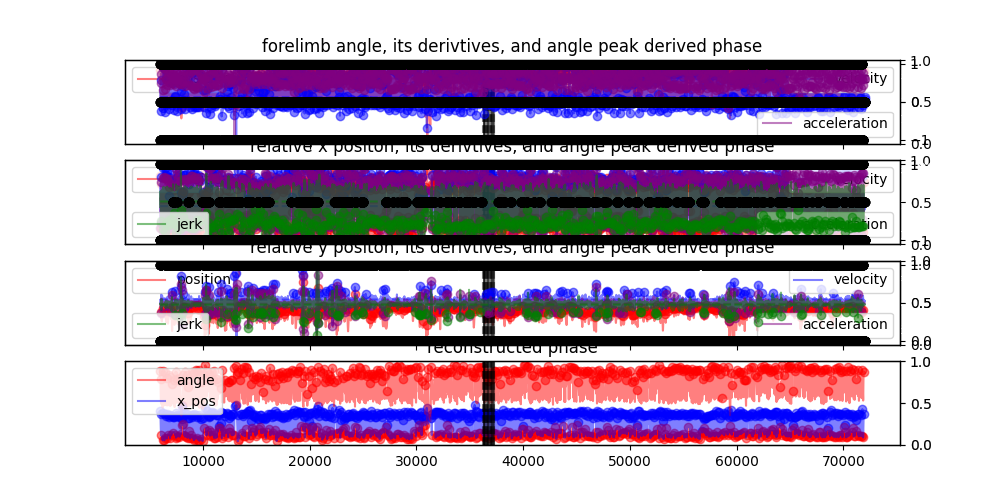

In [214]:
figq, (ax2, ax0, ax1, ax4) = plt.subplots(4, 1, figsize=(10,5),sharex = True)

ax22 = ax2.twinx()    
ax222 = ax2.twinx()    
ax2222 = ax2.twinx()    
ax222222 = ax2.twinx()    
ax2.plot(fnum, fore_angle, c = 'r', alpha = 0.5, label= 'position')
ax2.scatter(fnum[peaks_theta], fore_angle[peaks_theta], c = 'r', alpha = 0.5)
ax22.plot(fnum, dthetadt, c = 'b', alpha = 0.5,label = 'velocity')
ax22.scatter(fnum[peaks_dthetadt_plus], dthetadt[peaks_dthetadt_plus], c = 'b', alpha = 0.5)
ax22.scatter(fnum[peaks_dthetadt_minus], dthetadt[peaks_dthetadt_minus], c = 'b', alpha = 0.5)
ax22.plot(fnum, np.zeros(dthetadt.shape[0])+20, c = 'b', alpha = 0.5, linestyle = '--')
ax2222.plot(fnum, ddthetaddt, c = 'purple', alpha = 0.5, label = 'acceleration')
ax2222.scatter(fnum[peaks_ddthetaddt_plus], ddthetaddt[peaks_ddthetaddt_plus], c = 'purple', alpha = 0.5)
ax2222.scatter(fnum[peaks_ddthetaddt_minus], ddthetaddt[peaks_ddthetaddt_minus], c = 'purple', alpha = 0.5)
ax2222.plot(fnum, np.zeros(ddthetaddt.shape[0]), c = 'purple', alpha = 0.5, linestyle = '--')
# ax22222.plot(fnum, dddthetadddt, c = 'green', alpha = 0.5, label = 'jerk')
# ax22222.scatter(fnum[peaks_dddthetadddt_minus], dddthetadddt[peaks_dddthetadddt_minus], c = 'green', alpha = 0.5)
# ax22222.plot(fnum, np.zeros(dddthetadddt.shape[0]), c = 'green', linestyle = '--', alpha = 0.5)
ax2.legend(loc='upper left')
ax22.legend(loc='upper right')
ax2222.legend(loc='lower right')
# ax22222.legend(loc='lower left')
ax2.tick_params(axis='y', colors='white')
ax22.tick_params(axis='y', colors='white')
ax2222.tick_params(axis='y', colors='white')
# ax22222.tick_params(axis='y', colors='white')
ax2.set_title("forelimb angle, its derivtives, and angle peak derived phase")
ax222222.scatter(fnum, insanity_check, c = 'k', alpha = 0.5)



ax00 = ax0.twinx()    
ax000 = ax0.twinx()    
ax0000 = ax0.twinx()    
ax00000 = ax0.twinx()  
ax000000 = ax0.twinx()
ax0.plot(fnum, rel_x, c = 'r', alpha = 0.5, label= 'position')
ax0.scatter(fnum[peaks_relx], rel_x[peaks_relx], c = 'r', alpha = 0.5)
ax0.scatter(fnum[neg_peaks_relx], rel_x[neg_peaks_relx], c = 'r', alpha = 0.5)

ax00.plot(fnum, dxdt, c = 'b', alpha = 0.5, label = 'velocity')
ax0000.plot(fnum, ddxddt, c = 'purple', alpha = 0.5, label = 'acceleration')
ax00000.plot(fnum, dddxdddt, c = 'green', alpha = 0.5, label = 'jerk')
ax0.legend(loc='upper left')
ax00.plot(fnum, np.zeros(dxdt.shape[0])+20, c = 'b', alpha = 0.5, linestyle = '--')
ax0000.plot(fnum, np.zeros(ddxddt.shape[0]), c = 'purple', alpha = 0.5, linestyle = '--')
ax00000.plot(fnum, np.zeros(dddxdddt.shape[0]), c = 'green', linestyle = '--', alpha = 0.5)
ax00.scatter(fnum[peaks_dxdt_plus], dxdt[peaks_dxdt_plus], c = 'b', alpha = 0.5)
# ax00.scatter(fnum[peaks_dxdt_minus], dxdt[peaks_dxdt_minus], c = 'b', alpha = 0.5)
ax0000.scatter(fnum[peaks_ddxddt_plus], ddxddt[peaks_ddxddt_plus], c = 'purple', alpha = 0.5)
ax0000.scatter(fnum[peaks_ddxddt_minus], ddxddt[peaks_ddxddt_minus], c = 'purple', alpha = 0.5)
ax00000.scatter(fnum[peaks_dddxdddt_minus], dddxdddt[peaks_dddxdddt_minus], c = 'green', alpha = 0.5)
ax000000.scatter(fnum, sanity_check, c = 'k', alpha = 0.5)

ax00.legend(loc='upper right')
ax0000.legend(loc='lower right')
ax00000.legend(loc='lower left')
ax0.tick_params(axis='y', colors='white')
ax00.tick_params(axis='y', colors='white')
ax0000.tick_params(axis='y', colors='white')
ax00000.tick_params(axis='y', colors='white')
ax0.set_title("relative x positon, its derivtives, and angle peak derived phase")



ax11 = ax1.twinx()    
ax111 = ax1.twinx()    
ax1111 = ax1.twinx()    
ax11111 = ax1.twinx()    
ax111111 = ax1.twinx()    

ax1.plot(fnum, rel_y, c = 'r', alpha = 0.5, label= 'position')
ax1.scatter(fnum[peaks_rely], rel_y[peaks_rely], c = 'r', alpha = 0.5)
ax11.plot(fnum, dydt, c = 'b', alpha = 0.5, label = 'velocity')
ax1111.plot(fnum, ddyddt, c = 'purple', alpha = 0.5, label = 'acceleration')
ax11111.plot(fnum, dddydddt, c = 'green', alpha = 0.5, label = 'jerk')
ax1.legend(loc='upper left')
ax11.plot(fnum, np.zeros(dydt.shape[0])+20, c = 'b', alpha = 0.5, linestyle = '--')
ax1111.plot(fnum, np.zeros(ddyddt.shape[0]), c = 'purple', alpha = 0.5, linestyle = '--')
ax11111.plot(fnum, np.zeros(dddydddt.shape[0]), c = 'green', linestyle = '--', alpha = 0.5)
ax11.scatter(fnum[peaks_dydt_plus], dydt[peaks_dydt_plus], c = 'b', alpha = 0.5)
# ax11.scatter(fnum[peaks_dydt_minus], dydt[peaks_dydt_minus], c = 'b', alpha = 0.5)
ax1111.scatter(fnum[peaks_ddyddt_plus], ddyddt[peaks_ddyddt_plus], c = 'purple', alpha = 0.5)
ax1111.scatter(fnum[peaks_ddyddt_minus], ddyddt[peaks_ddyddt_minus], c = 'purple', alpha = 0.5)
ax11111.scatter(fnum[peaks_dddydddt_minus], dddydddt[peaks_dddydddt_minus], c = 'green', alpha = 0.5)
ax11.legend(loc='upper right')
ax1111.legend(loc='lower right')
ax11111.legend(loc='lower left')
ax1.tick_params(axis='y', colors='white')
ax11.tick_params(axis='y', colors='white')
ax1111.tick_params(axis='y', colors='white')
ax11111.tick_params(axis='y', colors='white')
ax1.set_title("relative y positon, its derivtives, and angle peak derived phase")
ax111111.scatter(fnum, y_swing, c = 'k', alpha = 0.5)


ax44 = ax4.twinx()    
ax444 = ax4.twinx()    
ax4444 = ax4.twinx()    
ax44444=  ax4.twinx()    
ax4.plot(fnum, fore_angle, c = 'r', alpha = 0.5, label= 'angle')
ax4.scatter(fnum[peaks_theta], fore_angle[peaks_theta], c = 'r', alpha = 0.5)
ax4.plot(fnum, rel_x, c = 'b', alpha = 0.5, label= 'x_pos')
ax4.scatter(fnum[peaks_relx], rel_x[peaks_relx], c = 'b', alpha = 0.5)
ax4.scatter(fnum[neg_peaks_relx], rel_x[neg_peaks_relx], c = 'r', alpha = 0.5)

# ax4444.scatter(fnum, insanity_check, c = 'r', alpha = 0.3)
# ax4444.scatter(fnum, sanity_check, c = 'b', alpha = 0.3)
# ax4444.scatter(fnum, for_democracy, c = 'y', alpha = 0.3)
# ax4444.scatter(fnum, voted_phase, c = 'k', alpha = 0.8)



ax4.legend(loc='upper left')
# ax44444.legend(loc='lower left')
ax4.tick_params(axis='y', colors='white')
ax4444.tick_params(axis='y', colors='white')
ax44.tick_params(axis='y', colors='white')
ax4.set_title("reconstructed phase")

ax2.axvline(x = 36230 , c = 'k', alpha = 0.5, linestyle = '--')
ax2.axvline(x = 36317 , c = 'k', alpha = 0.5, linestyle = '--')
ax2.axvline(x = 36397 , c = 'k', alpha = 0.5, linestyle = '--')
ax2.axvline(x = 36506 , c = 'k', alpha = 0.5, linestyle = '--')
ax2.axvline(x = 36619 , c = 'k', alpha = 0.5, linestyle = '--')
ax2.axvline(x = 36737 , c = 'k', alpha = 0.5, linestyle = '--')
ax2.axvline(x = 36867 , c = 'k', alpha = 0.5, linestyle = '--')
ax2.axvline(x = 36986 , c = 'k', alpha = 0.5, linestyle = '--')
ax2.axvline(x = 37114 , c = 'k', alpha = 0.5, linestyle = '--')
ax2.axvline(x = 37235 , c = 'k', alpha = 0.5, linestyle = '--')
ax2.axvline(x = 36284 , c = 'k', alpha = 0.5)
ax2.axvline(x = 36363 , c = 'k', alpha = 0.5)
ax2.axvline(x = 36469 , c = 'k', alpha = 0.5)
ax2.axvline(x = 36587 , c = 'k', alpha = 0.5)
ax2.axvline(x = 36695 , c = 'k', alpha = 0.5)
ax2.axvline(x = 36829 , c = 'k', alpha = 0.5)
ax2.axvline(x = 36949 , c = 'k', alpha = 0.5)
ax2.axvline(x = 37082 , c = 'k', alpha = 0.5)
ax2.axvline(x = 37200 , c = 'k', alpha = 0.5)
ax2.axvline(x = 37306 , c = 'k', alpha = 0.5)

ax0.axvline(x = 36230 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 36317 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 36397 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 36506 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 36619 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 36737 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 36867 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 36986 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 37114 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 37235 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 36284 , c = 'k', alpha = 0.5)
ax0.axvline(x = 36363 , c = 'k', alpha = 0.5)
ax0.axvline(x = 36469 , c = 'k', alpha = 0.5)
ax0.axvline(x = 36587 , c = 'k', alpha = 0.5)
ax0.axvline(x = 36695 , c = 'k', alpha = 0.5)
ax0.axvline(x = 36829 , c = 'k', alpha = 0.5)
ax0.axvline(x = 36949 , c = 'k', alpha = 0.5)
ax0.axvline(x = 37082 , c = 'k', alpha = 0.5)
ax0.axvline(x = 37200 , c = 'k', alpha = 0.5)
ax0.axvline(x = 37306 , c = 'k', alpha = 0.5)

ax1.axvline(x = 36230 , c = 'k', alpha = 0.5, linestyle = '--')
ax1.axvline(x = 36317 , c = 'k', alpha = 0.5, linestyle = '--')
ax1.axvline(x = 36397 , c = 'k', alpha = 0.5, linestyle = '--')
ax1.axvline(x = 36506 , c = 'k', alpha = 0.5, linestyle = '--')
ax1.axvline(x = 36619 , c = 'k', alpha = 0.5, linestyle = '--')
ax1.axvline(x = 36737 , c = 'k', alpha = 0.5, linestyle = '--')
ax1.axvline(x = 36867 , c = 'k', alpha = 0.5, linestyle = '--')
ax1.axvline(x = 36986 , c = 'k', alpha = 0.5, linestyle = '--')
ax1.axvline(x = 37114 , c = 'k', alpha = 0.5, linestyle = '--')
ax1.axvline(x = 37235 , c = 'k', alpha = 0.5, linestyle = '--')
ax1.axvline(x = 36284 , c = 'k', alpha = 0.5)
ax1.axvline(x = 36363 , c = 'k', alpha = 0.5)
ax1.axvline(x = 36469 , c = 'k', alpha = 0.5)
ax1.axvline(x = 36587 , c = 'k', alpha = 0.5)
ax1.axvline(x = 36695 , c = 'k', alpha = 0.5)
ax1.axvline(x = 36829 , c = 'k', alpha = 0.5)
ax1.axvline(x = 36949 , c = 'k', alpha = 0.5)
ax1.axvline(x = 37082 , c = 'k', alpha = 0.5)
ax1.axvline(x = 37200 , c = 'k', alpha = 0.5)
ax1.axvline(x = 37306 , c = 'k', alpha = 0.5)

ax4.axvline(x = 36230 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 36317 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 36397 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 36506 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 36619 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 36737 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 36867 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 36986 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 37114 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 37235 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 36284 , c = 'k', alpha = 0.5)
ax4.axvline(x = 36363 , c = 'k', alpha = 0.5)
ax4.axvline(x = 36469 , c = 'k', alpha = 0.5)
ax4.axvline(x = 36587 , c = 'k', alpha = 0.5)
ax4.axvline(x = 36695 , c = 'k', alpha = 0.5)
ax4.axvline(x = 36829 , c = 'k', alpha = 0.5)
ax4.axvline(x = 36949 , c = 'k', alpha = 0.5)
ax4.axvline(x = 37082 , c = 'k', alpha = 0.5)
ax4.axvline(x = 37200 , c = 'k', alpha = 0.5)
ax4.axvline(x = 37306 , c = 'k', alpha = 0.5)